<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/CTC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!git clone --recursive https://github.com/parlance/ctcdecode.git
!cd ctcdecode && pip install .

Cloning into 'ctcdecode'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1059 (delta 5), reused 7 (delta 2), pack-reused 1047
Receiving objects: 100% (1059/1059), 759.79 KiB | 14.07 MiB/s, done.
Resolving deltas: 100% (508/508), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 86, done.        
remote: Counting objects: 100% (86/86), done.        
remote: Compressing objects: 100% (60/60), done.        
remote: Total 13668 (delta 39), reused 53

In [3]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())
dev = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)  

# ------------------------------ Loading of raw data ------------------------------

# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Split into sequences according to end indices
train_sequences = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
test_sequences = np.split(data_set_test, data_end_index_test)[:-1]

# Conver to tensor
train_sequences = [torch.from_numpy(seq) for seq in train_sequences]
test_sequences = [torch.from_numpy(seq) for seq in test_sequences]
print('Train: split data into {} phrases.'.format(len(train_sequences)))
print('Test: split data into {} phrases.'.format(len(test_sequences)))

vocab_list = ['aa','ae','ah','ao','aw','ax','ax-h','axr','ay','b','bcl','ch',
              'd','dcl','dh','dx','eh','el','em','en','eng','epi','er','ey',
              'f','g','gcl','h#','hh','hv','ih','ix','iy','jh','k','kcl','l',
              'm','n','ng','nx','ow','oy','p','pau','pcl','q','r','s','sh',
              't','tcl','th','uh','uw','ux','v','w','y','z','zh', '_']


CUDA available:  True
Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [26]:
# Utils

def collapse_repeated(sequence):
  """
  Receives list of labels and remove the ones that are repeated consecutively
  
  E.g. [27 27 28 28 28] -> [27, 28]

  """

  if len(sequence) == 0:
    return sequence
  
  diff = np.diff(sequence).astype(np.bool)
  idx = np.insert(diff, 0, True)
  sequence_reduced = sequence[idx]

  return sequence_reduced

def print_distances(distances, token1Length, token2Length):
  for t1 in range(token1Length + 1):
      for t2 in range(token2Length + 1):
          print(int(distances[t1][t2]), end=" ")
      print()

def levenshtein_distance(token1, token2, debug=False):
  """
  Computes the Edit Distance between two sequences.
  """
  distances = numpy.zeros((len(token1) + 1, len(token2) + 1))

  for t1 in range(len(token1) + 1):
    distances[t1][0] = t1

  for t2 in range(len(token2) + 1):
    distances[0][t2] = t2
        
  a = 0
  b = 0
  c = 0
  
  for t1 in range(1, len(token1) + 1):
    for t2 in range(1, len(token2) + 1):
      if (token1[t1-1] == token2[t2-1]):
          distances[t1][t2] = distances[t1 - 1][t2 - 1]
      else:
          a = distances[t1][t2 - 1]
          b = distances[t1 - 1][t2]
          c = distances[t1 - 1][t2 - 1]             
          min_dist = min((a,b,c))

          distances[t1][t2] = min_dist + 1

  if debug:
    print_distances(distances, len(token1), len(token2))
    
  return distances[len(token1)][len(token2)]


In [29]:
# Decoding
from dataclasses import dataclass
from typing import List
from ctcdecode import CTCBeamDecoder

# *********************************************************************** #
#                           Decoding
# *********************************************************************** #
@dataclass 
class Decoder():
  blank_label: int
  remove_blanks: bool = True
  collapse_repeated: bool = True

  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    pass

@dataclass
class GreedyDecoder(Decoder):

  def decode(self, sequences, sequence_lens=None, *args, **kwargs):
    """
    For each timestemp, takes the label with maximum probability.
    Optionally removes consecutively repeated labels and blank labels.
  
    :param sequences: torch tensor [batch, sequence len, number of classes]
    :param sequence_lens: list of sequence lengths for each sequence in batch
    :return: list of decoded sequences (different lengths).
    """

    decoded_sequences = []
    for sequence, seq_len in zip(sequences, sequence_lens):
      seq = sequence[:seq_len]  # Remove pads
      decoded_seq = torch.argmax(seq, dim=1)
    
      if self.collapse_repeated:
        decoded_seq = collapse_repeated(decoded_seq.cpu())
        decoded_seq = decoded_seq.to(dev)
      
      if self.remove_blanks:
        decoded_seq = decoded_seq[decoded_seq != self.blank_label]

      decoded_sequences.append(decoded_seq)

    return decoded_sequences

@dataclass
class BeamSearchDecoder(Decoder):
  labels: List = None
  model_path: str = None
  alpha: float = 0.0
  beta: float = 0.0 
  cutoff_top_n: int = 40
  cutoff_prob: float = 1.0
  beam_width: int = 3
  num_processes: int = 4
  blank_id: int = 0
  log_probs_input: bool = True

  def __post_init__(self):
    self._decoder = CTCBeamDecoder(labels=self.labels,
                                   model_path=self.model_path,
                                   alpha=self.alpha,
                                   beta=self.beta,
                                   cutoff_top_n=self.cutoff_top_n,
                                   cutoff_prob=self.cutoff_prob,
                                   beam_width=self.beam_width,
                                   num_processes=self.num_processes,
                                   blank_id=self.blank_id, # This should be the index of the CTC blank token # Maybe it should be blank_label - 1?
                                   log_probs_input=self.log_probs_input)
    
  def decode(self, sequences, sequence_lens=None *args, **kwargs):
    """
    :param sequences: [batch, number of timesteps, number of classes]
    """
    beam_result, beam_scores, timesteps, out_seq_len = self._decoder.decode(sequences, )
    # beam_result [batchsize, n_beams, n_timesteps]
    # TODO: convert to decoded output and return
    decoded_sequences = []

    for sequence,out_len in zip(beam_result, out_seq_len):
      beam_number = 0
      decoded_sequence = sequence[beam_number][:out_len[beam_number]]
      decoded_sequence = decoded_sequence.to(device)
      decoded_sequences.append(decoded_sequence)

      # TODO: put in base class
      if self.collapse_repeated:
        decoded_sequence = collapse_repeated(decoded_sequence.cpu())
        decoded_sequence = decoded_sequence.to(device)
      
      if self.remove_blanks:
        decoded_sequence = decoded_sequence[decoded_sequence != self.blank_label]

    return decoded_sequences


def label_error_rate(predicted_sequences, target_sequences, predicted_lens, target_lens, debug=False):
  total_distance = 0
  
  nr_batches = len(predicted_sequences)

  for i in range(nr_batches):
    pred_seq = predicted_sequences[i]
    target_seq = target_sequences[i]
    predicted_len = predicted_lens[i]
    target_len = target_lens[i]

    pred_seq = pred_seq[:predicted_len]
    target_seq = target_seq[:target_len]

    dist = levenshtein_distance(pred_seq, target_seq)
    total_distance += dist

  target_total_len = sum(target_lens)
  label_err_rate = float(total_distance)/float(target_total_len)*100  # Although LER it's not a real percentage, as it could be > %100
  
  if debug:
    print("Total distance ", total_distance)
    print("Target total len ", target_total_len)

  return label_err_rate

In [30]:
import numpy
import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.optim as optim
from torch.nn import CTCLoss, LogSoftmax
from torch.nn.functional import log_softmax

FEATURE_DIM = 13 
NR_PHONEMES = 61
BLANK_LABEL = 61  # 0 to 60 are used
PADDING_VALUE = -1 


# *********************************************************************** #
#                           Hyper parameters
# *********************************************************************** #

BATCH_SIZE = 3
NUM_EPOCHS = 10
learning_rate = 0.01
momentum = 0.9
hidden_size = 100
layer_size = 2 # Number of layers

BEAM_WIDTH = 3 # Only used if decoding with Beam search

decoder = GreedyDecoder(blank_label=BLANK_LABEL)
decoder = BeamSearchDecoder(labels=vocab_list, blank_label=BLANK_LABEL, 
                            beam_width=BEAM_WIDTH, log_probs_input=True,
                            blank_id=BLANK_LABEL)

# *********************************************************************** #
#                             Dataset
# *********************************************************************** #

class SpeechDataset(Dataset):
  def __init__(self, list_of_sequences):
    self.data = list_of_sequences
    self.n_samples = len(list_of_sequences)
    self.seq_lens = [len(seq) for seq in list_of_sequences]
    self.n_frames = sum(self.seq_lens)

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return self.n_samples


train_dataset = SpeechDataset(train_sequences)
test_dataset = SpeechDataset(test_sequences)

print("Train Samples: {}".format(len(train_dataset)))
print("Train frames: ", train_dataset.n_frames)
print("Test Samples: {}".format(len(test_dataset)))
print("Test frames: ", test_dataset.n_frames)
print()


def collate_timit(batch):
    """
    batch: list of numpy arrays of different lengths
    """
    # Get length for each sequence
    input_lens = [sequence.shape[0] for sequence in batch]
    
    # Pad sequences to max length in batch
    batch_padded = pad_sequence(batch, batch_first=True, padding_value=PADDING_VALUE)
    batch_padded = torch.as_tensor(batch_padded)
    
    # Get batched input
    x_batch = batch_padded[:,:,:-1]
    
    # Obtain targets
    y_batch = [seq[:,-1] for seq in batch]

    # Remove repeated consecutive labels in target sequences: (E.g. [27 27 28 28 28 61] -> [27 28 61])
    # NOTE: This is done to make targets shorter than input, so that nn.CTCLoss doesn't yield infinite values
    y_batch_reduced = []
    target_lens = []
    for y_seq in y_batch: # Loop over each sequence
      y_seq_reduced = collapse_repeated(y_seq)
      y_batch_reduced.append(y_seq_reduced)
      target_lens.append(len(y_seq_reduced))

    # Pad target sequences
    y_batch_padded = pad_sequence(y_batch_reduced, batch_first=True, padding_value=PADDING_VALUE)
    
    y_batch = torch.as_tensor(y_batch_padded)
    
    return x_batch, y_batch, input_lens, target_lens


# *********************************************************************** #
#                           Model
# *********************************************************************** #

class BLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BLSTMModel, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers

    # Hidden layer
    # batch_first=True means input/output tensors to be of shape
    # (batch_dim, seq_dim, feature_dim)
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.nr_layers, 
                        batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    # Input is hidden_size*2 because it has a bidirectional LSTM as previous layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

    self.log_softmax = LogSoftmax(dim=2)

  def forward(self, x, seq_lens): # x has shape [batch_size, max_seq_len, nr_coef]

    x_packed = pack_padded_sequence(x, lengths=seq_lens, batch_first=True, enforce_sorted=False) # x_packed.data has shape [nr_batch_frames, nr_coefs]
    out_lstm, _ = self.lstm(x_packed) # out_lstm.data has shape [nr_batch_frames, nr_coefs]

    out_lstm_padded, out_lens = pad_packed_sequence(out_lstm, batch_first=True, padding_value=PADDING_VALUE) # [batch_size, sequences_max_len, nr_coefs]

    out = self.fc(out_lstm_padded) # [batch_size, sequences_max_len, nr_classes] 
    # CTCLoss will ignore the padding values as sequences lengths from input and target are passed to it

    
    return out, out_lens


# *********************************************************************** #
#                        Train & Test functions
# *********************************************************************** #

def train_model(model, data_loader):

  model.train()
  
  epoch_loss = 0

  for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))): 
    # Save to device
    input_data = input_data.to(torch.float)
    target_data = target_data.to(torch.long)
    input_data, target_data = input_data.to(device), target_data.to(device)
    
    optimizer.zero_grad() # Clear grads before doing backward
    
    # Forward pass
    model_out, out_lens = model(input_data, seq_lens) # [batch_size, seq_len, classes]

    # Prepare CTC inputs
    model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
    model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
    input_lens = out_lens.to(torch.long)
    target_lens = torch.tensor(target_lens, dtype=torch.long)

    batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
    epoch_loss += batch_loss.item()
    
    # Backward pass
    batch_loss.backward()
    optimizer.step()

  epoch_loss = epoch_loss/len(data_loader.dataset) # Divide by number of sequences

  return epoch_loss

def test_model(model, data_loader):

  # This will notify all the layers that it's eval mode, that way, 
  # batchnorm or dropout layers will work in eval mode instead of training mode.
  model.eval()

  total_loss = 0
  nr_correct_frames = 0
  total_frames = 0
  label_err_rates = []
  
  # no_grad impacts the autograd engine and deactivate it. 
  # It will reduce memory usage and speed up computations 
  # and it won’t be able to backprop (which is not desired 
  # in an eval script).
  with torch.no_grad(): 
    for batch_idx, (input_data, target_data, seq_lens, target_lens) in enumerate(tqdm.notebook.tqdm((data_loader))):
      input_data = input_data.to(torch.float)
      target_data = target_data.to(torch.long)
      input_data, target_data = input_data.to(device), target_data.to(device)  
      
      model_out, out_lens = model(input_data, seq_lens)

      # Prepare CTC inputs
      model_out = log_softmax(model_out, dim=2) # [batch_size, sequences_max_len, nr_classes]
      model_out_permuted = model_out.permute(1,0,2) # [seq_len, batch_size, classes] 
      input_lens = out_lens.to(torch.long)
      target_lens = torch.tensor(target_lens, dtype=torch.long) 

      # Compute loss
      batch_loss = cost_function(model_out_permuted.cpu(), target_data.cpu(), input_lens.cpu(), target_lens.cpu())
      total_loss += batch_loss.item()

      # Predict
      #predictions = greedy_decoding(model_out, input_lens, blank_label=BLANK_LABEL, 
      #                              remove_blanks=True, collapse_repeated=True)
      
      predictions = decoder.decode(model_out, input_lens)
      
      # Get error
      label_err_rate = label_error_rate(predictions, target_data, input_lens, target_lens)
      label_err_rates.append(label_err_rate)

  average_loss = total_loss/len(data_loader.dataset) # Divide by number sequences
  avg_label_err_rate = sum(label_err_rates)/len(label_err_rates)

  print(label_err_rates)
  print(avg_label_err_rate)

  return average_loss, avg_label_err_rate


# **************************** Instantiate model & train ******************************** #

input_size = FEATURE_DIM
output_size = NR_PHONEMES + 1  # Number of phonemes + 1 for blank label

model = BLSTMModel(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

cost_function = nn.CTCLoss(blank=BLANK_LABEL, zero_infinity=False)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

print("Created BLSTM model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)
print("Batch size: ", BATCH_SIZE)

losses = []
label_error_rates = []

for epoch in range(NUM_EPOCHS):
  print("Epoch nr: ", epoch + 1)

  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  train_loss = train_model(model, train_loader)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_timit)
  test_loss, test_label_error_rate = test_model(model, test_loader)
  losses.append(test_loss)
  label_error_rates.append(test_label_error_rate)
  print("---- Training results ----")
  print("Loss:", train_loss)
  print("---- Test results ----")
  print("Loss:", test_loss)
  print("Label error rate:", test_label_error_rate)
  print()

Train Samples: 3696
Train frames:  1124823
Test Samples: 192
Test frames:  57919

Created BLSTM model with parameters:
Input size:  13
Hidden size:  100
Layer size:  2
Output size:  62
Batch size:  3
Epoch nr:  1



[96.49122807017544, 98.0392156862745, 91.02564102564102, 95.3125, 94.66666666666667, 98.52941176470588, 97.59036144578313, 93.47826086956522, 97.05882352941177, 95.45454545454545, 97.97979797979798, 98.0392156862745, 96.73913043478261, 97.46835443037975, 97.8021978021978, 96.66666666666667, 98.09523809523809, 94.54545454545455, 95.06172839506173, 98.75, 97.72727272727273, 97.32142857142857, 98.05825242718447, 95.32710280373831, 94.5945945945946, 94.94949494949495, 98.9795918367347, 95.50561797752809, 97.27272727272728, 96.66666666666667, 95.95959595959596, 96.49122807017544, 99.14529914529915, 96.36363636363636, 96.93877551020408, 97.87234042553192, 96.52173913043478, 97.47899159663865, 96.55172413793103, 97.14285714285714, 98.33333333333333, 97.03703703703704, 99.21875, 97.2972972972973, 97.61904761904762, 97.79411764705883, 95.1923076923077, 96.875, 96.8503937007874, 97.14285714285714, 96.85534591194968, 95.7983193277311, 96.31901840490798, 96.25, 98.75776397515527, 97.2972972972973


[92.98245614035088, 94.11764705882352, 80.76923076923077, 84.375, 90.66666666666666, 86.76470588235294, 87.95180722891565, 91.30434782608695, 86.76470588235294, 86.36363636363636, 86.86868686868688, 87.25490196078431, 91.30434782608695, 86.07594936708861, 86.81318681318682, 87.77777777777777, 88.57142857142857, 88.18181818181819, 91.35802469135803, 92.5, 95.45454545454545, 85.71428571428571, 86.40776699029125, 89.7196261682243, 89.1891891891892, 87.87878787878788, 88.77551020408163, 87.64044943820225, 91.81818181818183, 95.83333333333334, 90.9090909090909, 88.59649122807018, 94.01709401709401, 90.9090909090909, 87.75510204081633, 84.39716312056737, 86.08695652173914, 86.5546218487395, 86.20689655172413, 92.38095238095238, 84.16666666666667, 91.11111111111111, 96.09375, 90.09009009009009, 88.09523809523809, 85.29411764705883, 94.23076923076923, 88.28125, 88.18897637795276, 88.57142857142857, 88.67924528301887, 91.59663865546219, 88.34355828220859, 88.75, 90.06211180124224, 87.837837837


[77.19298245614034, 74.50980392156863, 62.82051282051282, 60.9375, 70.66666666666667, 61.76470588235294, 71.08433734939759, 65.21739130434783, 66.17647058823529, 69.31818181818183, 66.66666666666666, 59.80392156862745, 66.30434782608695, 72.15189873417721, 64.83516483516483, 66.66666666666666, 64.76190476190476, 65.45454545454545, 67.90123456790124, 72.5, 77.27272727272727, 62.5, 61.165048543689316, 64.48598130841121, 67.56756756756756, 68.68686868686868, 66.3265306122449, 57.30337078651685, 73.63636363636363, 69.16666666666667, 66.66666666666666, 61.40350877192983, 66.66666666666666, 65.45454545454545, 59.183673469387756, 68.08510638297872, 63.47826086956522, 70.58823529411765, 68.10344827586206, 65.71428571428571, 67.5, 62.96296296296296, 76.5625, 65.76576576576578, 60.317460317460316, 64.70588235294117, 69.23076923076923, 67.1875, 65.35433070866141, 61.42857142857143, 66.66666666666666, 69.74789915966386, 68.09815950920245, 68.75, 66.45962732919256, 68.24324324324324, 67.1052631578


[63.1578947368421, 54.90196078431373, 44.871794871794876, 46.875, 49.333333333333336, 47.05882352941176, 51.80722891566265, 48.91304347826087, 45.588235294117645, 53.40909090909091, 51.515151515151516, 48.03921568627451, 48.91304347826087, 50.63291139240506, 45.05494505494506, 45.55555555555556, 51.42857142857142, 43.63636363636363, 53.086419753086425, 42.5, 51.13636363636363, 47.32142857142857, 50.48543689320388, 40.18691588785047, 56.75675675675676, 46.464646464646464, 43.87755102040816, 40.44943820224719, 50.0, 50.0, 46.464646464646464, 43.859649122807014, 55.55555555555556, 45.45454545454545, 42.857142857142854, 50.35460992907801, 49.56521739130435, 52.10084033613446, 52.58620689655172, 55.23809523809524, 49.166666666666664, 51.11111111111111, 60.9375, 45.04504504504504, 42.06349206349206, 48.529411764705884, 53.84615384615385, 51.5625, 48.031496062992126, 45.714285714285715, 49.056603773584904, 47.05882352941176, 52.14723926380368, 53.75, 50.931677018633536, 55.4054054054054, 47.


[56.14035087719298, 54.90196078431373, 41.02564102564102, 37.5, 36.0, 39.705882352941174, 45.78313253012048, 43.47826086956522, 38.23529411764706, 35.22727272727273, 49.494949494949495, 43.13725490196079, 46.73913043478261, 45.56962025316456, 43.956043956043956, 45.55555555555556, 44.761904761904766, 43.63636363636363, 39.50617283950617, 38.75, 38.63636363636363, 39.285714285714285, 39.80582524271845, 37.38317757009346, 44.14414414414414, 38.38383838383838, 41.83673469387755, 42.69662921348314, 46.36363636363636, 40.833333333333336, 42.42424242424242, 39.473684210526315, 51.28205128205128, 40.909090909090914, 34.69387755102041, 43.262411347517734, 44.34782608695652, 48.739495798319325, 45.689655172413794, 44.761904761904766, 41.66666666666667, 42.22222222222222, 53.90625, 39.63963963963964, 35.714285714285715, 44.85294117647059, 42.30769230769231, 42.96875, 48.031496062992126, 41.42857142857143, 41.509433962264154, 44.537815126050425, 44.785276073619634, 44.375, 44.72049689440994, 44.


[50.877192982456144, 47.05882352941176, 44.871794871794876, 34.375, 32.0, 30.88235294117647, 45.78313253012048, 31.521739130434785, 42.64705882352941, 36.36363636363637, 44.44444444444444, 42.15686274509804, 44.565217391304344, 40.50632911392405, 41.75824175824176, 40.0, 36.19047619047619, 39.09090909090909, 34.5679012345679, 32.5, 34.090909090909086, 32.142857142857146, 34.95145631067961, 35.51401869158878, 46.846846846846844, 36.36363636363637, 40.816326530612244, 39.325842696629216, 42.72727272727273, 42.5, 41.41414141414141, 35.08771929824561, 52.991452991452995, 39.09090909090909, 35.714285714285715, 41.13475177304964, 40.869565217391305, 43.69747899159664, 42.241379310344826, 41.904761904761905, 37.5, 38.51851851851852, 53.125, 42.34234234234234, 36.507936507936506, 41.911764705882355, 40.38461538461539, 37.5, 43.30708661417323, 36.42857142857142, 37.735849056603776, 41.17647058823529, 46.012269938650306, 41.875, 42.2360248447205, 41.891891891891895, 40.78947368421053, 43.333333


[54.385964912280706, 47.05882352941176, 42.30769230769231, 37.5, 32.0, 30.88235294117647, 38.55421686746988, 40.21739130434783, 35.294117647058826, 35.22727272727273, 39.39393939393939, 42.15686274509804, 43.47826086956522, 43.037974683544306, 41.75824175824176, 37.77777777777778, 34.285714285714285, 36.36363636363637, 35.80246913580247, 35.0, 36.36363636363637, 33.035714285714285, 37.86407766990291, 39.25233644859813, 42.34234234234234, 32.323232323232325, 37.755102040816325, 38.20224719101123, 38.18181818181819, 43.333333333333336, 38.38383838383838, 32.45614035087719, 48.717948717948715, 33.63636363636363, 31.63265306122449, 38.297872340425535, 37.391304347826086, 44.537815126050425, 40.51724137931034, 36.19047619047619, 36.666666666666664, 37.77777777777778, 57.03125, 42.34234234234234, 33.33333333333333, 40.44117647058824, 40.38461538461539, 34.375, 37.79527559055118, 30.714285714285715, 35.84905660377358, 46.21848739495798, 43.558282208588956, 40.0, 40.993788819875775, 41.216216


[50.877192982456144, 41.17647058823529, 38.46153846153847, 35.9375, 28.000000000000004, 29.411764705882355, 42.168674698795186, 38.04347826086957, 35.294117647058826, 31.818181818181817, 40.4040404040404, 36.27450980392157, 45.65217391304348, 35.44303797468354, 35.16483516483517, 41.11111111111111, 35.23809523809524, 34.54545454545455, 25.925925925925924, 28.749999999999996, 37.5, 34.82142857142857, 36.89320388349515, 37.38317757009346, 42.34234234234234, 30.303030303030305, 31.63265306122449, 32.58426966292135, 31.818181818181817, 40.833333333333336, 40.4040404040404, 35.08771929824561, 45.2991452991453, 39.09090909090909, 31.63265306122449, 33.33333333333333, 34.78260869565217, 40.33613445378151, 41.37931034482759, 40.0, 28.333333333333332, 39.25925925925926, 47.65625, 34.234234234234236, 34.12698412698413, 38.23529411764706, 39.42307692307692, 35.15625, 37.79527559055118, 33.57142857142857, 35.22012578616352, 47.05882352941176, 41.717791411042946, 40.625, 38.50931677018634, 43.2432


[49.122807017543856, 39.21568627450981, 39.743589743589745, 35.9375, 32.0, 30.88235294117647, 40.963855421686745, 31.521739130434785, 33.82352941176471, 35.22727272727273, 40.4040404040404, 38.23529411764706, 45.65217391304348, 35.44303797468354, 38.46153846153847, 38.88888888888889, 35.23809523809524, 30.909090909090907, 30.864197530864196, 27.500000000000004, 31.818181818181817, 32.142857142857146, 34.95145631067961, 35.51401869158878, 36.93693693693694, 32.323232323232325, 36.734693877551024, 34.831460674157306, 29.09090909090909, 35.833333333333336, 40.4040404040404, 30.701754385964914, 44.44444444444444, 37.27272727272727, 31.63265306122449, 32.62411347517731, 33.04347826086956, 40.33613445378151, 39.6551724137931, 30.476190476190478, 30.0, 39.25925925925926, 49.21875, 35.13513513513514, 34.92063492063492, 35.294117647058826, 38.46153846153847, 33.59375, 40.15748031496063, 31.428571428571427, 35.22012578616352, 42.857142857142854, 41.717791411042946, 40.625, 40.37267080745342, 41


[50.877192982456144, 39.21568627450981, 38.46153846153847, 35.9375, 34.66666666666667, 32.35294117647059, 40.963855421686745, 29.347826086956523, 35.294117647058826, 34.090909090909086, 35.35353535353536, 40.19607843137255, 44.565217391304344, 32.91139240506329, 34.065934065934066, 38.88888888888889, 31.428571428571427, 32.72727272727273, 32.098765432098766, 27.500000000000004, 29.545454545454547, 34.82142857142857, 33.980582524271846, 35.51401869158878, 36.03603603603604, 30.303030303030305, 36.734693877551024, 28.08988764044944, 26.36363636363636, 35.833333333333336, 41.41414141414141, 27.192982456140353, 45.2991452991453, 33.63636363636363, 28.57142857142857, 38.297872340425535, 38.26086956521739, 41.17647058823529, 41.37931034482759, 29.523809523809526, 28.333333333333332, 40.0, 47.65625, 38.73873873873874, 30.952380952380953, 33.82352941176471, 31.73076923076923, 32.8125, 33.85826771653544, 32.142857142857146, 28.930817610062892, 41.17647058823529, 40.49079754601227, 40.0, 37.888

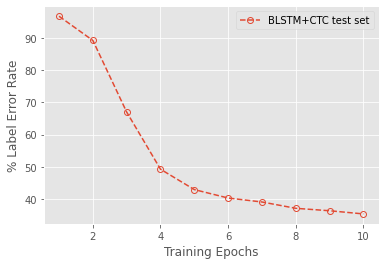

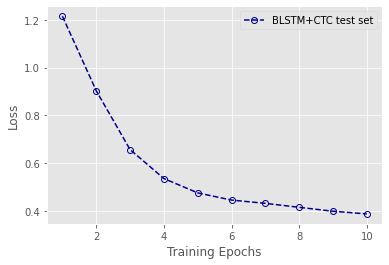

In [31]:
import datetime
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# ------------ Label error rates ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, label_error_rates, '--o', markerfacecolor='None', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='% Label Error Rate')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'LER_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

# ------------ Losses ----------------

fig, ax = plt.subplots()
epochs = np.arange(1, NUM_EPOCHS+1)
ax.plot(epochs, losses, '--o', markerfacecolor='None', color='darkblue', label='BLSTM+CTC test set')

ax.set(xlabel='Training Epochs', ylabel='Loss')

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/CTC/'
date_of_training = str(datetime.date.today())
filename = date_of_training + '_' + str(NUM_EPOCHS) + 'epochs' + suffix
learning_curve_filepath = root_path +'loss_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()